# Lab 2a: Kernelization
Support Vector Machines are powerful methods, but they also require careful tuning. We'll explore SVM kernels and hyperparameters on an artificial dataset. We'll especially look at model underfitting and overfitting.

In [10]:
# Auto-setup when running on Google Colab
if 'google.colab' in str(get_ipython()):
    !pip install openml

# General imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
from matplotlib import cm

## Getting the data
We fetch the Banana data from OpenML: https://www.openml.org/d/1460  

In [11]:
bananas = oml.datasets.get_dataset(1460) # Banana data has OpenML ID 1460
X, y, _, _ = bananas.get_data(target=bananas.default_target_attribute, dataset_format='array');

C:\Users\Lucas-PC\AppData\Local\Temp\ipykernel_11060\3794883227.py:1: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  bananas = oml.datasets.get_dataset(1460) # Banana data has OpenML ID 1460
C:\Users\Lucas-PC\AppData\Local\Temp\ipykernel_11060\3794883227.py:2: FutureWarning: Support for `dataset_format='array'` will be removed in 0.15,start using `dataset_format='dataframe' to ensure your code will continue to work. You can use the dataframe's `to_numpy` function to continue using numpy arrays.
  X, y, _, _ = bananas.get_data(target=bananas.default_target_attribute, dataset_format='array');


Quick look at the data:

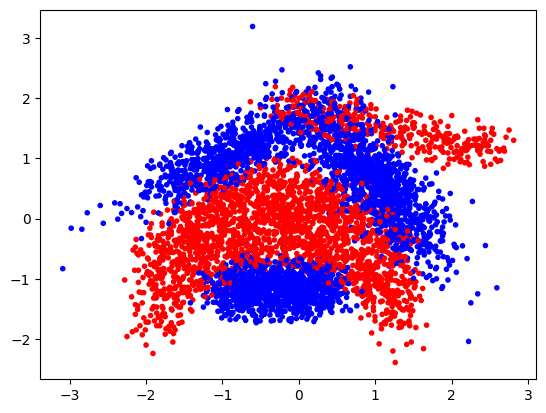

In [12]:
plt.scatter(X[:,0], X[:,1], c=y,cmap=plt.cm.bwr, marker='.');

In [13]:
# Plotting helpers. Based loosely on https://github.com/amueller/mglearn
def plot_svm_kernel(X, y, title, support_vectors, decision_function, dual_coef=None, show=True):
    """
    Visualizes the SVM model given the various outputs. It plots:
    * All the data point, color coded by class: blue or red
    * The support vectors, indicated by circling the points with a black border. 
      If the dual coefficients are known (only for kernel SVMs) if paints support vectors with high coefficients darker
    * The decision function as a blue-to-red gradient. It is white where the decision function is near 0.
    * The decision boundary as a full line, and the SVM margins (-1 and +1 values) as a dashed line
    
    Attributes:
    X -- The training data
    y -- The correct labels
    title -- The plot title
    support_vectors -- the list of the coordinates of the support vectores
    decision_function - The decision function returned by the SVM
    dual_coef -- The dual coefficients of all the support vectors (not relevant for LinearSVM)
    show -- whether to plot the figure already or not
    """
    # plot the line, the points, and the nearest vectors to the plane
    #plt.figure(fignum, figsize=(5, 5))
    plt.title(title)
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.bwr, marker='.')
    if dual_coef is not None:
        plt.scatter(support_vectors[:, 0], support_vectors[:, 1], c=dual_coef[0, :],
                    s=70, edgecolors='k', zorder=10, marker='.', cmap=plt.cm.bwr)
    else:
        plt.scatter(support_vectors[:, 0], support_vectors[:, 1], facecolors='none',
                    s=70, edgecolors='k', zorder=10, marker='.', cmap=plt.cm.bwr)
    plt.axis('tight')
    x_min, x_max = -3.5, 3.5
    y_min, y_max = -3.5, 3.5

    XX, YY = np.mgrid[x_min:x_max:300j, y_min:y_max:300j]
    Z = decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-1, 0, 1])
    plt.pcolormesh(XX, YY, Z, vmin=-1, vmax=1, cmap=plt.cm.bwr, alpha=0.1)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    plt.xticks(())
    plt.yticks(())

    if show:
        plt.show()
    
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    """
    Visualizes the results of a grid search with two hyperparameters as a heatmap.
    Attributes:
    values -- The test scores
    xlabel -- The name of hyperparameter 1
    ylabel -- The name of hyperparameter 2
    xticklabels -- The values of hyperparameter 1
    yticklabels -- The values of hyperparameter 2
    cmap -- The matplotlib color map
    vmin -- the minimum value
    vmax -- the maximum value
    ax -- The figure axes to plot on
    fmt -- formatting of the score values
    """
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=None, vmax=None)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)
    
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12, labelrotation=90)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(), img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center", size=10)
    return img

## Exercise 1: Linear SVMs

First, we'll look at linear SVMs and the different outputs they produce. Check the [documentation of LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)

The most important inputs are:  
* C -- The C hyperparameter controls the misclassification cost and therefore the amount of regularization. Lower values correspond to more regularization
* loss - The loss function, typically 'hinge' or 'squared_hinge'. Squared hinge is the default. Normal hinge is less strict.
* dual -- Whether to solve the primal optimization problem or the dual (default). The primal is recommended if you have many more data points than features (although our datasets is very small, so it won't matter much).

The most important outputs are:  
* decision_function - The function used to classify any point. In this case on linear SVMs, this corresponds to the learned hyperplane, or $y = \mathbf{wX} + b$. It can be evaluated at every point, if the result is positive the point is classified as the positive class and vice versa. 
* coef_ - The model coefficients, i.e. the weights $\mathbf{w}$
* intercept_ - the bias $b$

From the decision function we can find which points are support vectors and which are not: the support vectors are all
the points that fall inside the margin, i.e. have a decision value between -1 and 1, or that are misclassified. Also see the lecture slides.

### Exercise 1.1: Linear SVMs
Train a LinearSVC with C=0.001 and hinge loss. Then, use the plotting function `plot_svm_kernel` to plot the results. For this you need to extract the support vectors from the decision function. There is a hint below should you get stuck. 
Interpret the plot as detailed as you can. Afterwards you can also try some different settings. You can also try using the primal instead of the dual optimization problem (in that case, use squared hinge loss).

c:\Users\Lucas-PC\Documents\git\MLE-labs\.venv\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Lucas-PC\AppData\Local\Temp\ipykernel_11060\3010575611.py:28: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(support_vectors[:, 0], support_vectors[:, 1], facecolors='none',


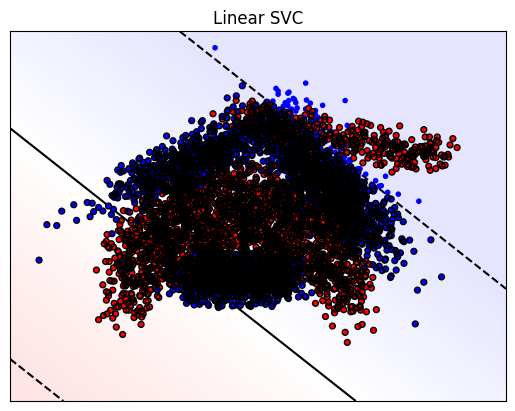

In [14]:
# Train a linear SVM
from sklearn.svm import LinearSVC
model = LinearSVC(C=0.001, loss='hinge')
model.fit(X, y)
support_vector_indices = np.where((2 * y - 1) * model.decision_function(X) <= 1)[0]
support_vectors = X[support_vector_indices]
plot_svm_kernel(X, y, "Linear SVC", support_vectors, model.decision_function)

## Exercise 2: Kernelized SVMs

Check the [documentation of SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

It has a few more inputs. The most important: 
* kernel - It must be either ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, or your custom defined kernel.
* gamma - The kernel width of the `rbf` (Gaussian) kernel. Smaller values mean wider kernels. 
          Only relevant when selecting the rbf kernel.
* degree - The degree of the polynomial kernel. Only relevant when selecting the poly kernel.

There also also more outputs that make our lifes easier:  
* support_vectors_ - The array of support vectors
* n_support_ - The number of support vectors per class
* dual_coef_ - The coefficients of the support vectors (the dual coefficients)

### Exercise 2.1

Evaluate different kernels, with their default hyperparameter settings.
Outputs should be the 5-fold cross validated accuracy scores for the linear kernel (lin_scores), polynomial kernel (poly_scores) and RBF kernel (rbf_scores). Print the mean and variance of the scores and give an initial interpretation of the performance of each kernel.

In [15]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
for kernel in ('linear', 'poly', 'rbf', 'sigmoid'):
    model = SVC(kernel=kernel)
    scores = cross_val_score(model, X, y, cv=5)
    print(kernel, np.mean(scores), np.std(scores))

linear 0.5516981132075471 0.0003773584905660599
poly 0.6377358490566037 0.005500898014005022
rbf 0.9024528301886793 0.007370575465896081
sigmoid 0.2922641509433962 0.012013401796023851


## Exercise 2: Visualizing the fit
To better understand what the different kernels are doing, let's visualize their predictions.

### Exercise 2.1
Call and fit SVM with linear, polynomial and RBF kernels with default parameter values. For RBF kernel, use kernel coefficient value (gamma) of 2.0. Plot the results for each kernel with "plot_svm_kernel" function. The plots show the predictions made for the different kernels. The background color shows the prediction (blue or red). The full line shows the decision boundary, and the dashed line the margin. The encircled points are the support vectors.

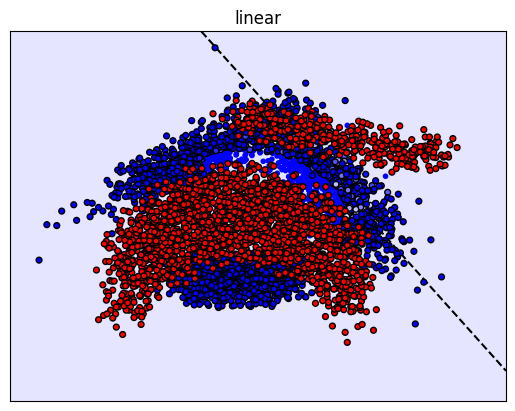

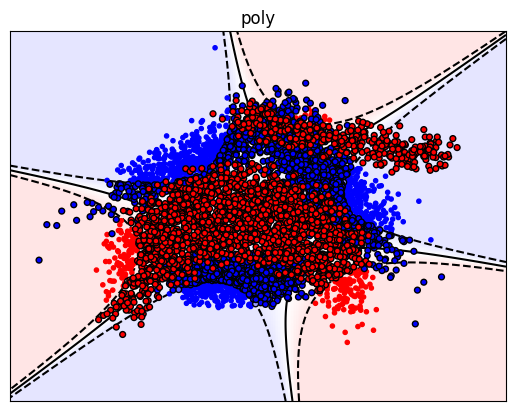

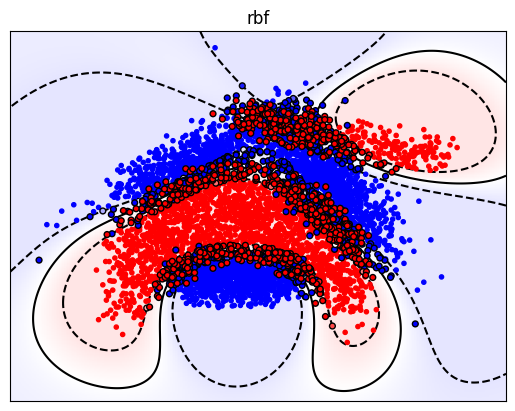

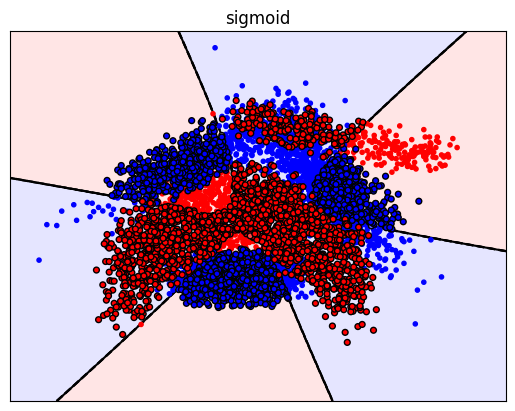

In [16]:
for kernel in ('linear', 'poly', 'rbf', 'sigmoid'):
    model = SVC(kernel=kernel)
    model.fit(X, y)
    plot_svm_kernel(X, y, kernel, model.support_vectors_, model.decision_function, model.dual_coef_)

### Exercise 2.2
Interpret the plots for each kernel. Think of ways to improve the results.

They all show different functions as decision boundaries. This boundaries could be tighter so regularisation may improve the results.

## Exercise 3: Visualizing the RBF models and hyperparameter space
Select the RBF kernel and optimize the two most important hyperparameters (the 𝐶 parameter and the kernel width 𝛾 ).

Hint: values for C and $\gamma$ are typically in [$2^{-15}..2^{15}$] on a log scale. 

### Exercise 3.1
First try 3 very different values for $C$ and $\gamma$ (for instance [1e-3,1,1e3]). For each of the 9 combinations, create the same RBF plot as before to understand what the model is doing. Also create a standard train-test split and report the train and test score. Explain the performance results. When are you over/underfitting? Can you see this in the predictions?

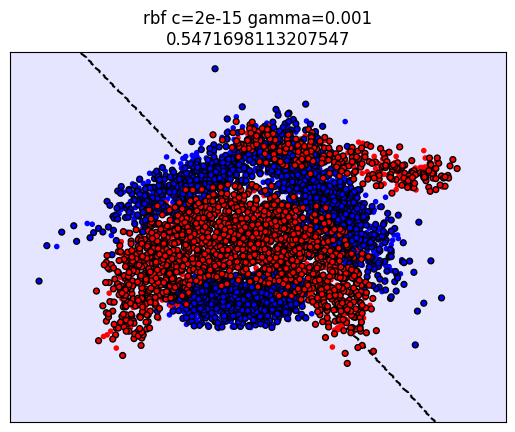

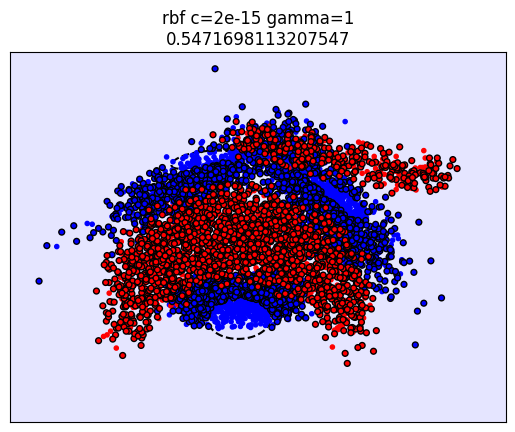

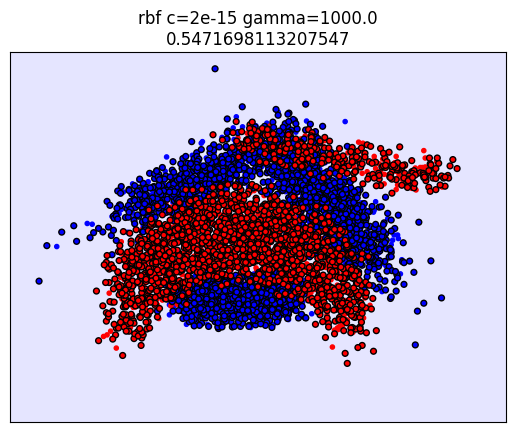

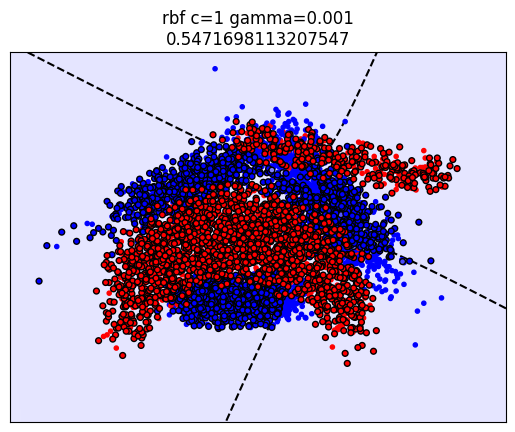

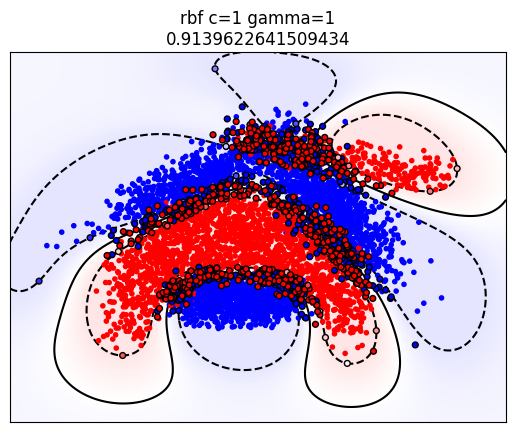

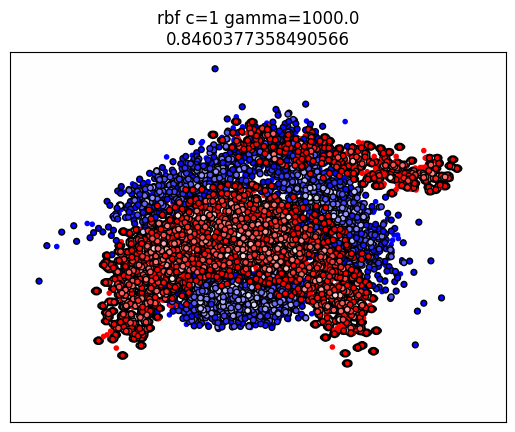

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True)
for C in (2e-15, 1, 2e15):
    for gamma in (1e-3, 1, 1e3):
        model = SVC(kernel='rbf', C=C, gamma=gamma)
        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)
        plot_svm_kernel(X, y, f"rbf c={C} gamma={gamma}\n{score}", model.support_vectors_, model.decision_function, model.dual_coef_)

### Exercise 3.2
Optimize the hyperparameters using a grid search, trying every possible combination of C and gamma. Show a heatmap of the results and report the optimal hyperparameter values. Use at least 10 values for $C$ and $\gamma$ in [$2^{-15}..2^{15}$] on a log scale. Report accuracy under 3-fold CV. We recommend to use sklearn's [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and the `heatmap` function defined above. Check their documentation.

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
param_grid = {'C': np.logspace(-15, 15, 10), 'gamma': np.logspace(-15, 15, 10)}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=3)
grid.fit(X, y)
heatmap(grid.cv_results_['mean_test_score'].reshape(10, 10), 'C', 'gamma', param_grid['C'], param_grid['gamma'], cmap='viridis')

NameError: name 'X' is not defined